### Imports and setup

In [ ]:
import numpy as np
import pandas as pd
import sys
import heapq
from tabulate import tabulate

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import Adam

np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)
pd.set_option("display.max_rows", 100000)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 10000)
pd.set_option("display.max_colwidth", 10000)

### Task 1

##### Part a - Exploratory data analytics on text data

In [ ]:
def fit(word_list):
    vectorizer = CountVectorizer()
    vectorizer.fit(word_list)
    return vectorizer

def concatenate_paragraphs(df):
    global print_abstract
    all_text:str = ''
    for index, row in df.iterrows():
        abstract = str(row['Text'])
        all_text += abstract
    return [all_text]

def create_df_with_extracted_features(df, vectorizer):
    vocabulary_sorted = dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1]))
    words_sorted = [key for key in vocabulary_sorted.keys()]
    extracted_features = []
    for index, row in df.iterrows():
        text = [row['Text']]
        extracted_features.append(vectorizer.transform(text).toarray()[0])
    df1 = pd.DataFrame(extracted_features)
    df1.columns = words_sorted
    new_df = pd.concat([df.drop('Text', axis=1), df1], axis=1)
    return new_df

def test_new_df(new_df):
    print(df.iloc[0].loc['Text'])
    first_row = new_df.iloc[0]
    for idx in range(2, len(first_row)):
        column_name = new_df.columns[idx]
        value = first_row.iloc[idx]
        if value > 0:
            print(f"Column: {column_name}, Value: {value}")

# ArticleId, Text, Category(tech, entertainment)
df = pd.concat([pd.read_csv('train.csv'), pd.read_csv('test.csv')], axis=0).reset_index(drop=True)
df_tech = df[df['Category'] == 'tech']
df_entertainment = df[df['Category'] == 'entertainment']
vectorizer_all = fit(concatenate_paragraphs(df))
vectorizer_tech = fit(concatenate_paragraphs(df_tech))
vectorizer_entertainment = fit(concatenate_paragraphs(df_entertainment))

new_df = create_df_with_extracted_features(pd.read_csv('train.csv'), vectorizer_all)

print(f'The number of articles: {len(df)}')
print(f'The number of extracted features: {len(vectorizer_all.vocabulary_)}')
print('5 example articles with their extracted features using a dataframe:')
print(new_df.head(5))

The number of articles: 534
The number of extracted features: 14927
5 example articles with their extracted features using a dataframe:
   ArticleId       Category  00  000  000th  001st  0051  007  0100  0130  ...  zombie  zombies  zone  zonealarm  zones  zoom  zooms  zooropa  zorro  zutons
0       1976           tech   0    1      0      0     0    0     0     0  ...       0        0     0          0      0     0      0        0      0       0
1       1797  entertainment   0    0      0      0     0    0     0     0  ...       0        0     0          0      0     0      0        0      0       0
2       1866  entertainment   0    0      0      0     0    0     0     0  ...       0        0     0          0      0     0      0        0      0       0
3       1153  entertainment   0    0      0      0     0    0     0     0  ...       0        0     0          0      0     0      0        0      0       0
4        342  entertainment   0    0      0      0     0    0     0     0  ... 

##### Part bi - Top 50 term frequency distribution across the entire dataset

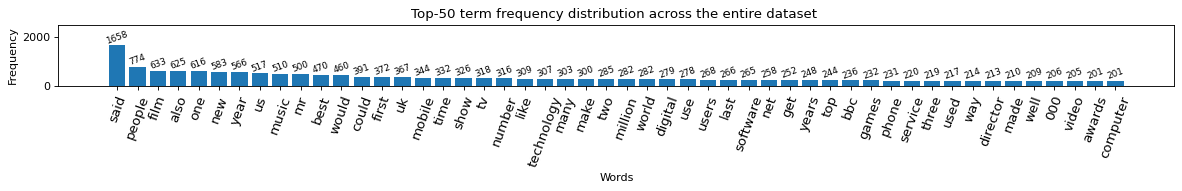

In [ ]:
def graph_top_50_frequency(df, vectorizer, category_text):
    all_text = concatenate_paragraphs(df)
    X = vectorizer.transform(all_text)
    word_counts = X.toarray().sum(axis=0)
    word_count_dict = {}
    vocabulary = vectorizer.vocabulary_
    # sort the vocabulary
    vocabulary_sorted = dict(sorted(vocabulary.items(), key=lambda item: item[1]))
    for word, count in zip(vocabulary_sorted, word_counts):
        word_count_dict[word] = count
    sorted_words = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)
    top_50_words = sorted_words[:50]
    x_labels = [item[0] for item in top_50_words]
    y_values = [item[1] for item in top_50_words]
    plt.figure(figsize=(18,1), dpi=80)
    plt.ylim(0,2500)
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 70)
    plt.bar(x_labels, y_values)
    for i, value in enumerate(y_values):
        plt.text(i, value, str(value), fontsize=8, rotation=20, ha='center', va='bottom')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top-50 term frequency distribution across the entire dataset {category_text}')
    plt.show()
    plt.rcdefaults()

graph_top_50_frequency(df, vectorizer_all,  '')

##### Part bii - Term frequency distribution for respective class of articles

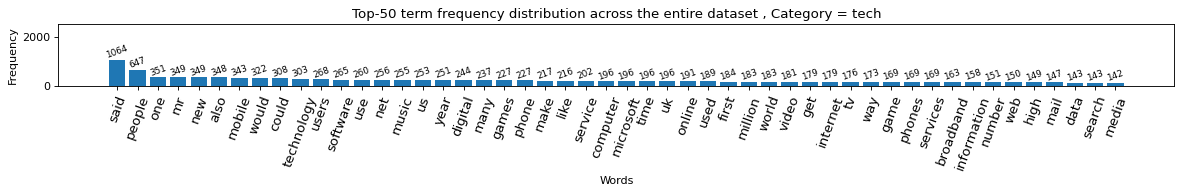

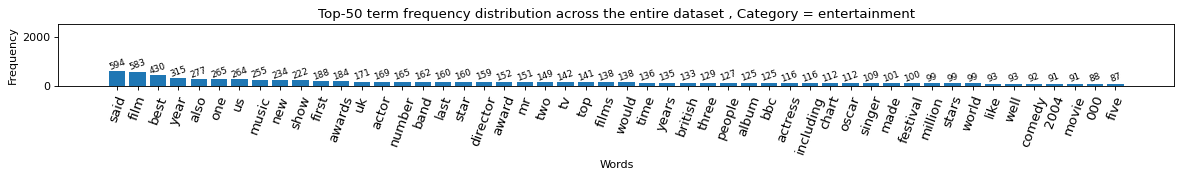

In [ ]:
graph_top_50_frequency(df_tech, vectorizer_tech, ', Category = tech')
graph_top_50_frequency(df_entertainment,  vectorizer_entertainment, ', Category = entertainment')

##### Part biii - The class distribution

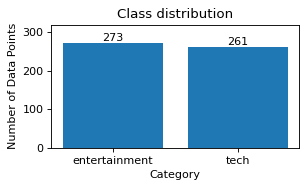

In [ ]:
def class_distribution(df):
    category_counts = df['Category'].value_counts()
    plt.figure(figsize=(4,2), dpi=80)
    plt.ylim(0,320)
    plt.bar(category_counts.index, category_counts.values)
    for i, value in enumerate(category_counts.values):
        plt.text(i, value, str(value), ha='center', va='bottom')
    plt.title('Class distribution')
    plt.xlabel('Category')
    plt.ylabel('Number of Data Points')
    plt.show()
    plt.rcdefaults()

class_distribution(df)

### Task 2

##### Part a - Naive Bayes

In [ ]:
df_test = pd.read_csv('test.csv')
test_df = create_df_with_extracted_features(df_test, vectorizer_all)

# Train a Naive Bayes classifier using all articles features.
NB_model_1 = MultinomialNB()
NB_model_1.fit(new_df.iloc[:,2:],new_df.iloc[:,1])

MultinomialNB()

##### Part ai - Top 20 most identifiable words that are most likely to occur in the articles over two classes

The top-20 most identifiable words that are most likely to occur in the ENTERTAINMENT articles are:
['said' 'film' 'best' 'year' 'music' 'also' 'us' 'new' 'one' 'show' 'first' 'awards' 'tv' 'last' 'uk' 'actor' 'number' 'band' 'mr' 'star']


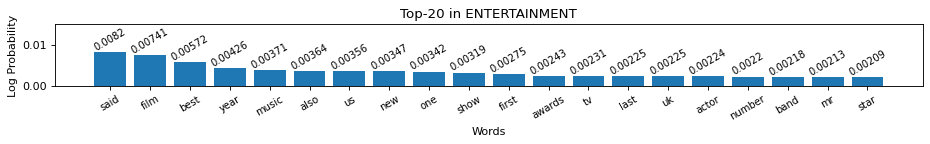


The top-20 most identifiable words that are most likely to occur in the TECH articles are:
['said' 'people' 'new' 'mobile' 'mr' 'one' 'also' 'would' 'could' 'technology' 'use' 'net' 'users' 'software' 'games' 'us' 'music' 'many' 'year' 'phone']


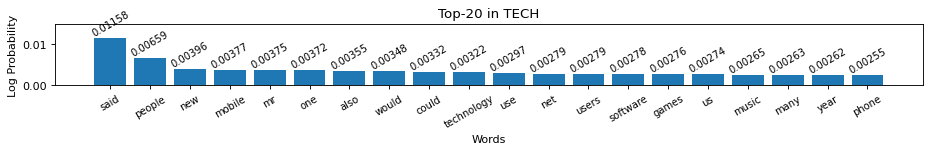

In [ ]:
for i in range(len(NB_model_1.classes_)):
    indices_of_top_20 = heapq.nlargest(20, range(len(NB_model_1.feature_log_prob_[i])), NB_model_1.feature_log_prob_[i].take)
    print("The top-20 most identifiable words that are most likely to occur in the", str.upper(NB_model_1.classes_[i]), "articles are:")
    print(NB_model_1.feature_names_in_[indices_of_top_20])

    # graphing
    x_labels = NB_model_1.feature_names_in_[indices_of_top_20]
    y_values = [round(np.exp(e),5) for e in NB_model_1.feature_log_prob_[i][indices_of_top_20]]
    plt.figure(figsize=(14,1), dpi=80)
    plt.ylim(0, 0.015)
    plt.xticks(fontsize = 9, horizontalalignment = 'center', rotation = 30)
    plt.bar(x_labels, y_values)
    for ind, value in enumerate(y_values):
        plt.text(ind, value, str(value), fontsize=9, rotation=30, ha='center', va='bottom')
    plt.xlabel('Words')
    plt.ylabel('Log Probability')
    plt.title(f'Top-20 in {str.upper(NB_model_1.classes_[i])}')
    plt.show()
    plt.rcdefaults()
    print()

##### Part aii - The top-20 words that maximize $\frac{P(X_w = 1 | Y = y)}{P(X_w = 1 | Y \neq y)}$

The top-20 most identifiable words that are most likely to occur in the ENTERTAINMENT articles but not in other articles are:
['actress' 'singer' 'oscar' 'stars' 'aviator' 'band' 'nominated' 'festival' 'rock' 'album' 'nominations' 'charles' 'chart' 'foxx' 'oscars' 'starring' 'singles' 'jamie' 'swank' 'comedy']


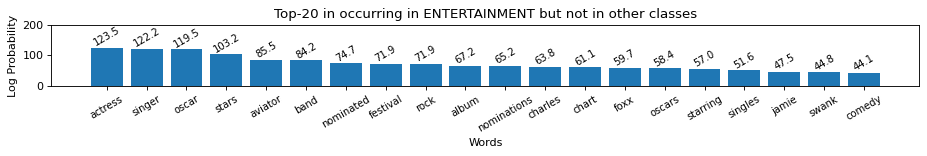


The top-20 most identifiable words that are most likely to occur in the TECH articles but not in other articles are:
['users' 'software' 'microsoft' 'mobile' 'broadband' 'virus' 'firms' 'pc' 'spam' 'phones' 'gadget' 'net' 'consumer' 'mobiles' 'gadgets' 'machines' 'windows' 'technologies' 'systems' 'device']


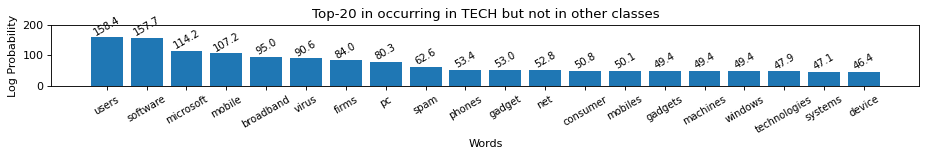

In [ ]:
for i in range(len(NB_model_1.classes_)):
    calculated_values = NB_model_1.feature_log_prob_[i]-NB_model_1.feature_log_prob_[int((i+1)%2)]
    indices_of_top_20 = heapq.nlargest(20, range(len(calculated_values)), calculated_values.take)
    print("The top-20 most identifiable words that are most likely to occur in the", str.upper(NB_model_1.classes_[i]), "articles but not in other articles are:")
    print(NB_model_1.feature_names_in_[indices_of_top_20])

    # graphing
    x_labels = NB_model_1.feature_names_in_[indices_of_top_20]
    y_values = [round(np.exp(e),1) for e in calculated_values[indices_of_top_20]]
    plt.figure(figsize=(14,1), dpi=80)
    plt.ylim(0,200)
    plt.xticks(fontsize = 9, horizontalalignment = 'center', rotation = 30)
    plt.bar(x_labels, y_values)
    for ind, value in enumerate(y_values):
        plt.text(ind, value, str(value), fontsize=9, rotation=30, ha='center', va='bottom')
    plt.xlabel('Words')
    plt.ylabel('Log Probability')
    plt.title(f'Top-20 in occurring in {str.upper(NB_model_1.classes_[i])} but not in other classes')
    plt.show()
    plt.rcdefaults()
    print()

The second two lists of identifying words in (ii) better describes the two classes.

This is because it takes into account the occurrence of the word in the selected class COMPARED to the occurrence of the word in other classes too.

As opposed to (i), which only looks at occurrence within the selected class.

##### Part b - KNN

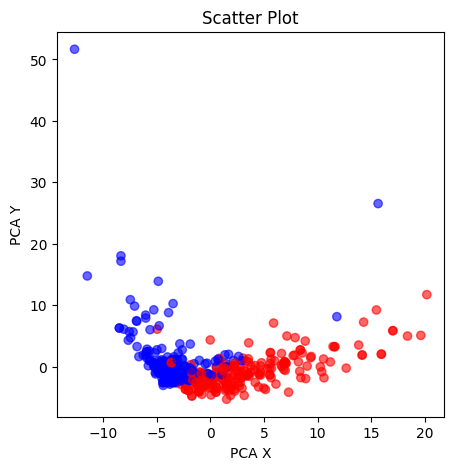

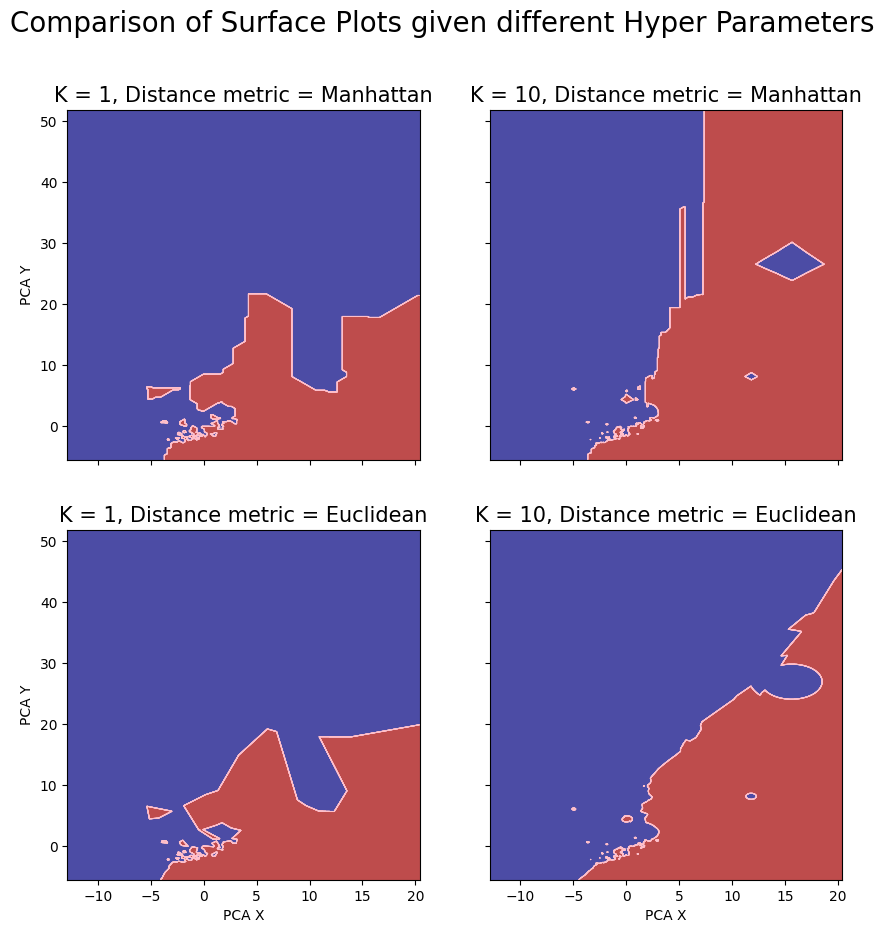

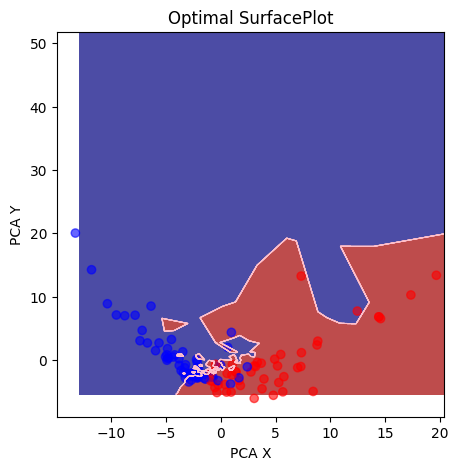

In [ ]:
#takes a model and a training dataset and returns the f score with respect to a test set vector matrix.
def evaluateKnn(knnModel,train_df,test_df,testVectorMatrix):
    knnVectorMatrix = train_df.drop(["ArticleId","Category"],axis=1)
    knnModel.fit(knnVectorMatrix,train_df["Category"])
    return(knnCalcF1(knnModel,testVectorMatrix,test_df["Category"]))

def calcAccuracy(knnModel,train_df,test_df,testVectorMatrix):
    knnVectorMatrix = train_df.drop(["ArticleId","Category"],axis=1)
    knnModel.fit(knnVectorMatrix,train_df["Category"])
    score = knnModel.score(testVectorMatrix,test_df["Category"])
    return score

#computes the f score
def knnCalcF1(knnModel,testVectorMatrix,test_df_category):
    predictions = knnModel.predict(testVectorMatrix)
    test_df_category.reset_index(drop=True, inplace=True)
    combined_df = pd.concat([test_df_category,pd.DataFrame(predictions,columns = ["Predictions"])],axis = 1)

    #f1 = 2* (precision * recall)/(precision + recall)
    #let tech be positive and entertainment be negative
    #precision = tp/(tp+fp)
    #recall = tp/tp+fn
    tp = len(combined_df[(combined_df["Category"] == "tech") & (combined_df["Predictions"] == "tech")])
    fp = len(combined_df[(combined_df["Category"] == "entertainment") & (combined_df["Predictions"] == "tech")])
    fn = len(combined_df[(combined_df["Category"] == "tech") & (combined_df["Predictions"] == "entertainment")])
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)


    f1 = 2*((precision*recall)/(precision+recall))
    return f1


#evaluates a single knn model 5 times with crossfold
def crossFoldEvaluation(knnModel,train_df,test_df,testVectorMatrix,training = False):
    #give the training data a shuffle
    train_df = train_df.sample(frac = 1,random_state = 3)

    #portion training size out into 5 groups
    portionSize = round(len(train_df)/5)
    groups=[]
    groups.append(train_df.iloc[:portionSize])
    groups.append(train_df.iloc[portionSize:2*portionSize])
    groups.append(train_df.iloc[2*portionSize:3*portionSize])
    groups.append(train_df.iloc[3*portionSize:4*portionSize])
    groups.append(train_df.iloc[4*portionSize:])

    fScores = []

    for i in range(0,5):
        if i == 0:
            train_data = pd.concat([groups[0],groups[1],groups[2],groups[3]])
        elif i == 1:
            train_data = pd.concat([groups[1],groups[2],groups[3],groups[4]])
        elif i == 2:
            train_data = pd.concat([groups[2],groups[3],groups[4],groups[0]])
        elif i == 3:
            train_data = pd.concat([groups[3],groups[4],groups[0],groups[1]])
        elif i == 4:
            train_data = pd.concat([groups[4],groups[0],groups[1],groups[2]])

        if training == False:
            fScores.append(evaluateKnn(knnModel,train_data,test_df,testVectorMatrix))

        else:
            fScores.append(evaluateKnn(knnModel,train_data,train_data,train_data.drop(["ArticleId","Category"],axis=1)))
    #returns average f score for model
    return sum(fScores)/5
#returns 2 lists for the results from the proportion test
def comparePortions(knnDataFrame,testVectorMatrix,test_df):
    portions = [0.1, 0.3, 0.5, 0.7, 0.9]
    resultsTest = []
    knnModel = KNeighborsClassifier(n_neighbors=1,weights = "distance",p=2)

    for i in range(0,5):

        portion = portions[i]
        train_df = knnDataFrame.sample(frac = portion,random_state = 0)
        y=evaluateKnn(knnModel,train_df,test_df,testVectorMatrix)
        resultsTest.append(y)


    resultsTrain = []
    knnModel = KNeighborsClassifier(n_neighbors=1,weights = "distance",p=2)
    for i in range(0,5):

        portion = portions[i]
        train_df = knnDataFrame.sample(frac = portion,random_state = 0)
        y=evaluateKnn(knnModel,train_df,train_df,train_df.drop(["ArticleId","Category"],axis=1))
        resultsTrain.append(y)


    return resultsTest,resultsTrain


#measure f score in relation changing hyper params and display graphs
def compareHyperParams(train_df,testVectorMatrix,test_df):
    resultsTestE = []
    resultsTrainE = []
    resultsTestM = []
    resultsTrainM = []
    xaxis = []
    for k in range(1,10):
        xaxis.append(k)
        knnModel = KNeighborsClassifier(n_neighbors=k,weights = "distance",p=2,n_jobs=-1)
        resultsTestE.append(crossFoldEvaluation(knnModel,train_df,test_df,testVectorMatrix))
    for k in range(1,10):
        knnModel = KNeighborsClassifier(n_neighbors=k,weights = "distance",p=2,n_jobs=-1)
        resultsTrainE.append(crossFoldEvaluation(knnModel,train_df,train_df,train_df.drop(["ArticleId","Category"],axis=1),training = True))
    for k in range(1,10):

        knnModel = KNeighborsClassifier(n_neighbors=k,weights = "distance",p=1,n_jobs=-1)
        resultsTestM.append(crossFoldEvaluation(knnModel,train_df,test_df,testVectorMatrix))
    for k in range(1,10):

        knnModel = KNeighborsClassifier(n_neighbors=k,weights = "distance",p=1,n_jobs=-1)
        resultsTrainM.append(crossFoldEvaluation(knnModel,train_df,train_df,train_df.drop(["ArticleId","Category"],axis=1),training=True))

    plt.figure(figsize=(5,5))
    plt.plot(xaxis,resultsTestE,label="Euclidean Test")
    plt.plot(xaxis,resultsTrainE,"-",label="Euclidean Train")
    plt.plot(xaxis,resultsTestM,label="Manhattan Test")
    plt.plot(xaxis,resultsTrainM,"-",label="Manhattan Train")
    plt.legend(loc="lower left")
    plt.title('Impact of Number of Neighbours on F1 Score')
    plt.xlabel('Number of Neighbours')
    plt.ylabel('F1 Score')
    plt.savefig("HyperParamGraph.png")




#plot the surface plots
def surfacePlot(knnDataFrame,test_df,testVectorMatrix):

    knnVectorMatrix = knnDataFrame.drop(["ArticleId","Category"],axis=1)
    pca = PCA(n_components = 2)
    reducedVectorMatrix = pca.fit_transform(knnVectorMatrix)
    reduced_df = pd.DataFrame(reducedVectorMatrix,columns = ["x","y"])

    reduced_df = pd.concat([knnDataFrame[["ArticleId","Category"]],reduced_df],axis = 1)

    colorsScatter = {"tech":"red","entertainment":"blue"}
    X = reduced_df[["x","y"]].to_numpy()
    Y = reduced_df["Category"].to_numpy()
    #setup subplots to display graphs neatly
    plt.figure(figsize=(5,5))
    plt.title('Scatter Plot')
    plt.xlabel('PCA X')
    plt.ylabel('PCA Y')
    plt.scatter(X[:,0], X[:,1], c = reduced_df["Category"].map(colorsScatter),alpha =0.6);

    plt.show
    fig, axs = plt.subplots(2, 2,figsize=(10,10))
    fig.suptitle("Comparison of Surface Plots given different Hyper Parameters", fontsize=20)

    surfaceKnn = KNeighborsClassifier(n_neighbors=1,weights = "distance",p=1,n_jobs=-1)
    surfaceKnn.fit(X,Y)
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = surfaceKnn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    for i in range(0,len(Z)):
        for j in range(0,len(Z[i])):
            if Z[i][j] == "tech":
                Z[i][j] =1
            else:
                Z[i][j] = 0



    xx = np.array(xx, dtype=float)
    yy = np.array(yy, dtype=float)
    Z = np.array(Z, dtype=float)
    axs[0,0].contourf(xx, yy, Z, cmap = "seismic", alpha=0.7)
    axs[0,0].contour(xx, yy, Z,colors= "pink", linewidths=0.7)
    axs[0,0].set_title("K = 1, Distance metric = Manhattan",fontsize = "15")




    #same but for higher k value
    surfaceKnn = KNeighborsClassifier(n_neighbors=10,weights = "distance",p=1,n_jobs=-1)
    surfaceKnn.fit(X,Y)
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = surfaceKnn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    for i in range(0,len(Z)):
        for j in range(0,len(Z[i])):
            if Z[i][j] == "tech":
                Z[i][j] =1
            else:
                Z[i][j] = 0


    xx = np.array(xx, dtype=float)
    yy = np.array(yy, dtype=float)
    Z = np.array(Z, dtype=float)
    axs[0,1].contourf(xx, yy, Z, cmap = "seismic", alpha=0.7)
    axs[0,1].contour(xx, yy, Z,colors= "pink", linewidths=0.7)
    axs[0,1].set_title("K = 10, Distance metric = Manhattan",fontsize = "15")

    #switch to euclidean distance measurement
    surfaceKnn = KNeighborsClassifier(n_neighbors=1,weights = "distance",p=2,n_jobs=-1)
    surfaceKnn.fit(X,Y)
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = surfaceKnn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    for i in range(0,len(Z)):
        for j in range(0,len(Z[i])):
            if Z[i][j] == "tech":
                Z[i][j] =1
            else:
                Z[i][j] = 0



    xx = np.array(xx, dtype=float)
    yy = np.array(yy, dtype=float)
    Z = np.array(Z, dtype=float)
    axs[1,0].contourf(xx, yy, Z, cmap = "seismic", alpha=0.7)
    axs[1,0].contour(xx, yy, Z,colors= "pink", linewidths=0.7)
    axs[1,0].set_title("K = 1, Distance metric = Euclidean",fontsize = "15")





    #same but for higher k value
    surfaceKnn = KNeighborsClassifier(n_neighbors=10,weights = "distance",p=2,n_jobs=-1)
    surfaceKnn.fit(X,Y)
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = surfaceKnn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    for i in range(0,len(Z)):
        for j in range(0,len(Z[i])):
            if Z[i][j] == "tech":
                Z[i][j] =1
            else:
                Z[i][j] = 0


    xx = np.array(xx, dtype=float)
    yy = np.array(yy, dtype=float)
    Z = np.array(Z, dtype=float)
    axs[1,1].contourf(xx, yy, Z, cmap = "seismic", alpha=0.7)
    axs[1,1].contour(xx, yy, Z,colors= "pink", linewidths=0.7)
    axs[1,1].set_title("K = 10, Distance metric = Euclidean",fontsize="15")
    for ax in axs.flat:
        ax.set(xlabel='PCA X', ylabel='PCA Y')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.show("newsurfaceplot.png")


    surfaceKnn = KNeighborsClassifier(n_neighbors=2,weights = "distance",p=2,n_jobs=-1)
    surfaceKnn.fit(X,Y)
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = surfaceKnn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    for i in range(0,len(Z)):
        for j in range(0,len(Z[i])):
            if Z[i][j] == "tech":
                Z[i][j] =1
            else:
                Z[i][j] = 0

    reducedTestVectorMatrix = pca.fit_transform(testVectorMatrix)
    reducedTest_df = pd.DataFrame(reducedTestVectorMatrix,columns = ["x","y"])
    reducedTest_df = pd.concat([test_df[["ArticleId","Category"]],reducedTest_df],axis = 1)
    XTest = reducedTest_df[["x","y"]].to_numpy()
    YTest = reducedTest_df["Category"].to_numpy()


    xx = np.array(xx, dtype=float)
    yy = np.array(yy, dtype=float)
    Z = np.array(Z, dtype=float)
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, cmap = "seismic", alpha=0.7)
    plt.contour(xx, yy, Z,colors= "pink", linewidths=0.7)
    plt.scatter(XTest[:,0], XTest[:,1], c = reducedTest_df["Category"].map(colorsScatter),alpha =0.6);
    plt.title("Optimal SurfacePlot")
    plt.xlabel("PCA X")
    plt.ylabel("PCA Y")
    plt.show("optimalsurfacePlots.png")


#copy data
knnDataFrame = new_df
#prep test data
knnTest_df = pd.read_csv('test.csv')
knnTestVectorMatrix = create_df_with_extracted_features(knnTest_df, vectorizer_all).drop(["ArticleId","Category"],axis = 1)
#functions to be used later
#compareHyperParams(knnDataFrame,knnTestVectorMatrix,knnTest_df)
#comparePortions(knnDataFrame,knnTestVectorMatrix,knnTest_df)
surfacePlot(knnDataFrame,knnTest_df,knnTestVectorMatrix)

##### Part c - SVM
Apply Principal Component Analysis (PCA) to the training dataset using a configuration of n_components = 2.

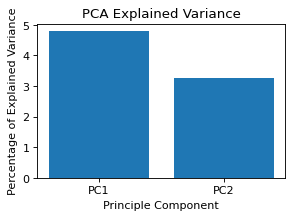

In [ ]:
#load data
x_df = new_df.iloc[:,2:]
y_train = np.array(new_df.iloc[:,1].map({'tech': 1, 'entertainment': 0}))

#PCA
min_max_scaler = MinMaxScaler()
pca = PCA(n_components=2)
x_train = min_max_scaler.fit_transform(pca.fit_transform(x_df))

pca_data = np.round(pca.explained_variance_ratio_, decimals=4)
labels = ['PC' + str(x) for x in range(1, len(pca_data) + 1)]

plt.figure(figsize=(4,2.5), dpi=80)
plt.xticks(fontsize = 10, horizontalalignment = 'center', rotation = 0)
plt.bar(x=range(1, len(pca_data) + 1), height = pca_data*100, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principle Component')
plt.title('PCA Explained Variance')
plt.show()

##### Part ci - The soft margin linear SVM with penalty $C$

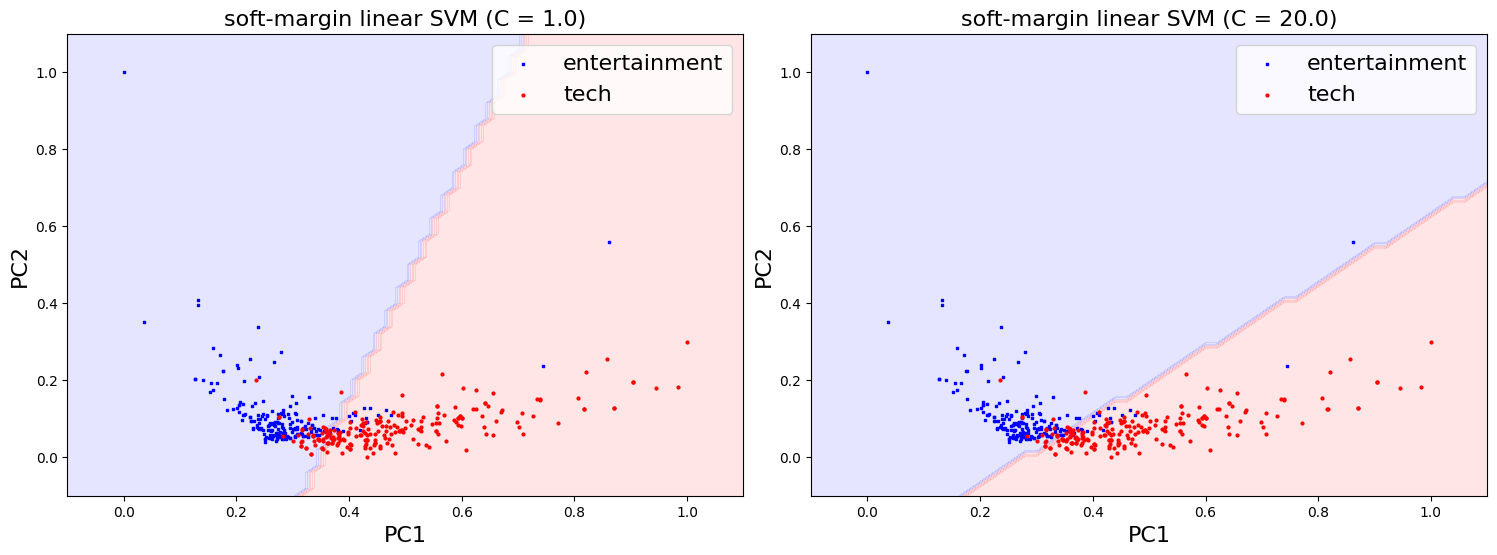

In [ ]:
def plot_decision_boundaries(X_train, y_train, classifier, ax):
    markers = ('s', 'o')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y_train))])

    # plot the decision surface
    x1_min, x1_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
    x2_min, x2_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    Z = classifier.predict(np.array([xx.ravel(), yy.ravel()]).T)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)

    # Plot the training points
    for idx, cl in enumerate(np.unique(y_train)):
        ax.scatter(x=X_train[y_train == cl, 0],
                    y=X_train[y_train == cl, 1],
                    s=4,
                    alpha=1.0,
                    color=colors[idx],
                    marker=markers[idx],
                    label= "tech" if cl == 1 else "entertainment")
    ax.set_xlabel('PC1', size=16)
    ax.set_ylabel('PC2', size=16)
    ax.legend(loc='upper right', fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [1.0, 20.0]):
    model = SVC(kernel='linear', C=C).fit(x_train, y_train)
    plot_decision_boundaries(x_train, y_train, model, axi)
    axi.set_title('soft-margin linear SVM (C = {0:.1f})'.format(C), size=16)

##### Part cii - Hard-margin RBF kernel with kernel width $\sigma$

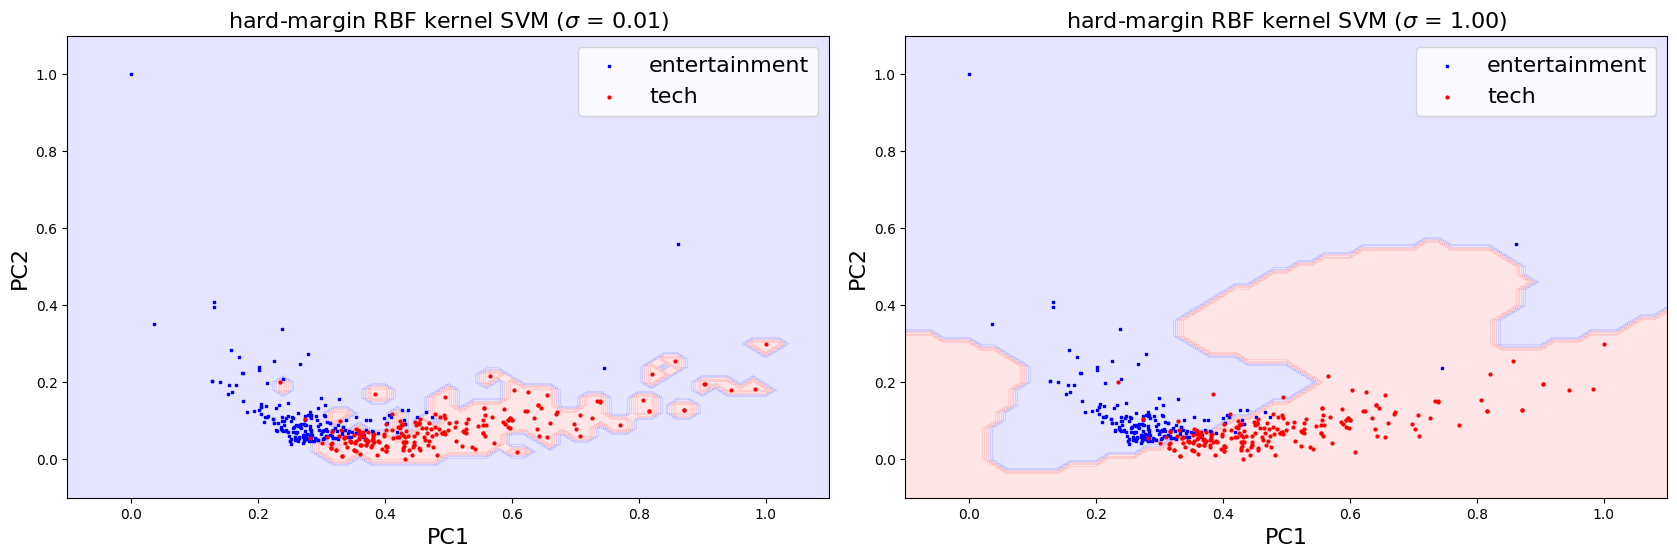

In [ ]:
def plot_decision_regions(X, y, ax, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'o')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    if ax is None: ax = plt.gca()

    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    s=4,
                    alpha=1,
                    color=colors[idx],
                    marker=markers[idx],
                    label= "tech" if cl == 1 else "entertainment")

    ax.set_xlabel('PC1', size=16)
    ax.set_ylabel('PC2', size=16)
    ax.legend(loc='upper right', fontsize=16)

#plot for the hard-margin RBF kernel SVM
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0, right=1, wspace=0.1)

for axi, sigma in zip(ax, [0.01, 1]):
    model = SVC(kernel='rbf', gamma=1/(2 * sigma**2), C = 1e6).fit(x_train, y_train)
    plot_decision_regions(x_train, y_train, axi, classifier=model)
    axi.set_title('hard-margin RBF kernel SVM ($\sigma$ = {0:.2f})'.format(sigma), size=16)

##### Part d - Neural network

   ArticleId                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

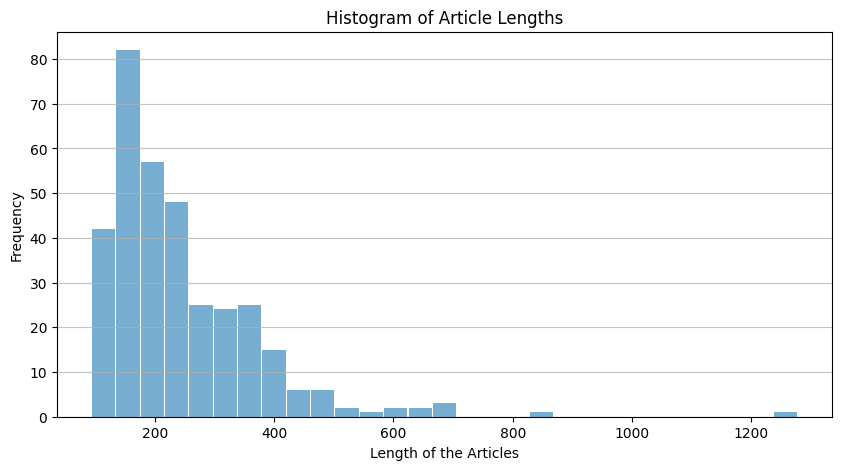

Epoch 1/5
18/18 [==============================] - 1s 20ms/step - loss: 0.6746 - accuracy: 0.4942 - val_loss: 0.5737 - val_accuracy: 0.5581
Epoch 2/5
18/18 [==============================] - 0s 13ms/step - loss: 0.4818 - accuracy: 0.6930 - val_loss: 0.3837 - val_accuracy: 0.9186
Epoch 3/5
18/18 [==============================] - 0s 12ms/step - loss: 0.3361 - accuracy: 0.9854 - val_loss: 0.3273 - val_accuracy: 0.9535
Epoch 4/5
18/18 [==============================] - 0s 12ms/step - loss: 0.2769 - accuracy: 1.0000 - val_loss: 0.3074 - val_accuracy: 0.9302
Epoch 5/5
18/18 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 1.0000

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)

data = pd.read_csv('train.csv')
print(data.head(5))

encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

train, test = train_test_split(data, test_size=0.2, random_state=1)

train_x = train['Text']
train_y = train['Category']

test_x = test['Text']
test_y = test['Category']



# I want to standardize the length of my inputs by padding my sentences
# Here I find the right amount to pad the begining of each input.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)


article_lengths = []


for s in train_x:

    # Convert the article to a sequence of integers
    seq = tokenizer.texts_to_sequences([s])

    # Calculate the length of this sequence
    sequence_length = len(seq[0])

    article_lengths.append(sequence_length)



# Checking the distribution of article lengths to select the best padding hyper-parameter
median_seq_len = np.median(article_lengths)
max_seq_len = np.max(article_lengths)
min_seq_len = np.min(article_lengths)
std_dev = round(np.std(article_lengths), 2)
q1 = np.percentile(article_lengths, 25)
q3 = np.percentile(article_lengths, 75)


# Printing the above info in a nice table


data = {
    'Min ': min_seq_len,
    '1st Quartile': q1,
    'Median ': median_seq_len,
    '3rd Quartile': q3,
    'Max ': max_seq_len,
    'Standard Deviation': std_dev,
}

table_data = [[k, v] for k, v in data.items()]
table = tabulate(table_data, headers=['Statistic', 'Value'], tablefmt='pretty')
print(table)


# Ploting the histogram of the article lengths
plt.figure(figsize=(10, 5))
plt.hist(article_lengths, bins='auto', alpha=0.6, rwidth=0.95)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Length of the Articles')
plt.ylabel('Frequency')
plt.title('Histogram of Article Lengths')
plt.show()

# To feed the sequences into this NN, I need to standardize their length.
# Padding the shorter sequences to make them into a vector of length 300.
# Cutting the longer sequences down to 300.
train_x = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=300)
test_x = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen=300)

vocab_size = len(tokenizer.word_index)
#adding 1 to vocab size to account for the padding character '0'.
embeding_seq_size = vocab_size + 1


# Creating a kernal initializer with so the weights will be uniformly distributed between 0 and 0.1
dense_initializer = RandomUniform(minval=0., maxval=0.1, seed = 1)
output_initializer = RandomUniform(minval=0., maxval=0.1, seed = 2)


hidden_units = [5, 20, 40]
avg_losses = []

for num_units in hidden_units:
    model = Sequential()
    model.add(Embedding(embeding_seq_size, 50, input_length=300))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(num_units, activation='relu', kernel_initializer=dense_initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=output_initializer))

    # Creating an Adam optimizer with learning rate set to 0.01
    Adam_optimizer = Adam(learning_rate=0.01)

    model.compile(loss='binary_crossentropy', optimizer=Adam_optimizer, metrics=['accuracy'])

    # Setting the shuffle parameter to false so the results are more reproducable
    history = model.fit(train_x, train_y, epochs=5, validation_data=(test_x, test_y), batch_size=20, shuffle=False)

    loss, accuracy = model.evaluate(test_x, test_y, verbose=0)

    avg_loss = np.mean(history.history['loss'])
    avg_losses.append(avg_loss)


# plotting the average training cross-entropy losses
plt.figure(figsize=(10,6))
plt.plot(hidden_units, avg_losses, marker='o')
plt.title('Average Training Cross-Entropy Loss vs Number of Hidden Units')
plt.ylabel('Average Training Cross-Entropy Loss')
plt.xlabel('Number of Hidden Units')
plt.show()

### Task 3

##### Part a

In [ ]:
m_values = [0.1, 0.3, 0.5, 0.7, 0.9]
def nb_comparePortions():
    m_values = [0.1, 0.3, 0.5, 0.7, 0.9]
    training_accuracy_NB = []
    testing_accuracy_NB = []
    x_train = new_df.iloc[:,2:]
    y_train = new_df.iloc[:,1]
    x_test = test_df.iloc[:,2:]
    y_test = test_df.iloc[:,1]
    num_of_examples = len(x_train)

    # For NB
    for m in m_values:
        new_NB_model = MultinomialNB()
        new_NB_model.fit(x_train.iloc[:int(m * num_of_examples)], y_train.iloc[:int(m * num_of_examples)])
        y_train_pred = new_NB_model.predict(x_train.iloc[:int(m * num_of_examples)])
        y_test_pred = new_NB_model.predict(x_test)
        f1_training = f1_score(y_train_pred, y_train.iloc[:int(m * num_of_examples)].values, average = "binary", pos_label = "tech")
        f1_testing = f1_score(y_test_pred, y_test, average = "binary", pos_label = "tech")
        training_accuracy_NB.append(f1_training)
        testing_accuracy_NB.append(f1_testing)
    return training_accuracy_NB, testing_accuracy_NB

def svm_comparePortions():
    m_values = [0.1, 0.3, 0.5, 0.7, 0.9]
    training_accuracy_SVM = []
    testing_accuracy_SVM = []
    x_train = new_df.iloc[:,2:]
    y_train = new_df.iloc[:,1]
    x_test = test_df.iloc[:,2:]
    y_test = test_df.iloc[:,1]
    num_of_examples = len(x_train)
    # For hard-margin RBF kernel SVM
    for m in m_values:
        sigma = 25
        new_SVM_model = SVC(kernel='rbf', gamma=1/(2 * sigma**2), C = 1e6)
        new_SVM_model.fit(x_train.iloc[:int(m * num_of_examples)], y_train.iloc[:int(m * num_of_examples)])
        y_train_pred = new_SVM_model.predict(x_train.iloc[:int(m * num_of_examples)])
        y_test_pred = new_SVM_model.predict(x_test)
        f1_training = f1_score(y_train_pred, y_train.iloc[:int(m * num_of_examples)].values, average = "binary", pos_label = "tech")
        f1_testing = f1_score(y_test_pred, y_test, average = "binary", pos_label = "tech")
        training_accuracy_SVM.append(f1_training)
        testing_accuracy_SVM.append(f1_testing)
    return training_accuracy_SVM, testing_accuracy_SVM

# A function to find the best cuttoff for a positive (Tech) vs a negative (Entertainment) class prediction
# using Youden's J statistic, the best threshold maximizes Youden's J statistic.
# For more info:
# Habibzadeh F, Habibzadeh P, Yadollahie M. On determining the most appropriate test cut-off value: the case of tests with continuous
# results. Biochem Med (Zagreb). 2016 Oct 15;26(3):297-307. doi: 10.11613/BM.2016.034. PMID: 27812299; PMCID: PMC5082211.
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic
def find_best_cuttoff(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    youdens_j = tpr - fpr
    optimal_idx = np.argmax(youdens_j)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def nn_comparePortions():
  # Vector of the portions of interest
  m_values = [0.1, 0.3, 0.5, 0.7, 0.9]
  train_accuracy = []
  test_accuracy = []

  N = len(train_x)

  for m in m_values:

      mN = int(m*N)
      train_x_m = train_x[:mN]
      train_y_m = train_y[:mN]

      model = Sequential()
      model.add(Embedding(embeding_seq_size, 50, input_length=300))
      model.add(GlobalAveragePooling1D())
      model.add(Dense(40, activation='relu', kernel_initializer=dense_initializer))
      model.add(Dense(1, activation='sigmoid', kernel_initializer=output_initializer))

      Adam_optimizer = Adam(learning_rate=0.01)
      model.compile(loss='binary_crossentropy', optimizer=Adam_optimizer, metrics=['accuracy'])

      # Training the model on m portion of the training set
      # Only training for 4 epochs after the last test
      model.fit(train_x_m, train_y_m, epochs=4, batch_size=20, shuffle=False, verbose=0)

      # Predicting probabilities of catefory 'Tech' for each dataset
      train_probs = model.predict(train_x_m)
      test_probs = model.predict(test_x)

      # Finding the optimal threshold using the training data
      optimal_threshold = find_best_cuttoff(train_y_m, train_probs)
      #print('The optimal threshold is: ' ,optimal_threshold)

      # Generating binary pradictions from the optimal threshold
      train_preds = []
      for p in train_probs:
          if p >= optimal_threshold:
              train_preds.append(1)
          else:
              train_preds.append(0)

      test_preds = []
      for p in test_probs:
          if p >= optimal_threshold:
              test_preds.append(1)
          else:
              test_preds.append(0)


      # Calculating the F1 score for the training and test sets
      train_accuracy.append(f1_score(train_y_m, train_preds))
      test_accuracy.append(f1_score(test_y, test_preds))
  return train_accuracy, test_accuracy

#get NB results
training_accuracy_NB, testing_accuracy_NB = nb_comparePortions()

#get knn results
knnTestResults,knnTrainResults = comparePortions(knnDataFrame,knnTestVectorMatrix,knnTest_df)

#get svm results
svmTrainingResults, svmTestResults = svm_comparePortions()

#get NN results
nnTrainingResults, nnTestResults = nn_comparePortions()

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(m_values, training_accuracy_NB,label = "NB")
axs[0].plot(m_values, knnTrainResults,label="KNN")
axs[0].plot(m_values, svmTrainingResults,label="SVM")
axs[0].plot(m_values, nnTrainingResults,label="NN")
axs[0].set_title('F1 Performance on Training Data')
axs[0].set_xlabel('Portion of Training Data used')
axs[0].set_ylabel('F1 score')
axs[0].legend(loc="lower left")
axs[1].plot(m_values, testing_accuracy_NB,label = "NB")
axs[1].plot(m_values, knnTestResults,label="KNN")
axs[1].plot(m_values, svmTestResults,label="SVM")
axs[1].plot(m_values, nnTestResults,label="NN")
axs[1].set_title('F1 Performance on Testing Data')
axs[1].set_xlabel('Portion of Training Data used')
axs[1].set_ylabel('F1 score')
axs[1].legend(loc="lower left")

##### Part b

In [ ]:
x_train = new_df.iloc[:,2:]
y_train = new_df.iloc[:,1]
x_test = test_df.iloc[:,2:]
y_test = test_df.iloc[:,1]

def cross_validation(model, x, y, folds):
    kf=KFold(n_splits=folds,shuffle=False)
    scores = []
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        model.fit(x.iloc[train_index], y.iloc[train_index])
        fold_predictions = model.predict(x.iloc[test_index])
        scores.append(f1_score(fold_predictions, y.iloc[test_index], average = "binary", pos_label = "tech"))
    avg_score = np.sum(np.array(scores))/len(scores)
    return avg_score

tuning_alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 1]
cv_accuracies = []
for tuning_alpha in tuning_alphas:
    new_NB_model = MultinomialNB(alpha = tuning_alpha)
    cv_accuracies.append(cross_validation(new_NB_model, x_train, y_train, 5))

print("Task 3b:\n")
print("Naives Bayes\n")
print("The tested hyper parameter alphas for the NB model are:")
print(tuning_alphas)
print("\nTheir corresponding F1 scores after 5-fold cross validation are:")
print([round(e,5) for e in cv_accuracies])

plt.figure(figsize=(7,4), dpi=80)
plt.plot(tuning_alphas, cv_accuracies)
plt.title('Testing F1 Accuracy for NB')
plt.xlabel('Alpha')
plt.ylabel('F1 score')
plt.show()

print("\nThe tuned hyper parameter alpha is", tuning_alphas[np.argmax(cv_accuracies)], "with an F1 score of", round(max(cv_accuracies), 5))

In [ ]:
#3b knn optimal hyper params graph
compareHyperParams(knnDataFrame,knnTestVectorMatrix,knnTest_df)


In [ ]:
print("Task 3b - hard-margin RBF kernel SVM:")
x_train = new_df.iloc[:,2:]
y_train = new_df.iloc[:,1]
x_test = test_df.iloc[:,2:]
y_test = test_df.iloc[:,1]
cv_accuracy_SVM = []
test_accuracy_SVM = []
sigma_values = ['0.01', '0.1', '0.5', '1', '10', '18', '25', '50']
for sigma in sigma_values:
    # Perform 5-fold cross-validation and obtain accuracy scores
    mean_accuracy = cross_val_score(SVC(kernel='rbf', gamma=1/(2 * float(sigma)**2), C = 1e6), x_train, y_train, cv=5).mean()
    cv_accuracy_SVM.append(mean_accuracy)
    #re-train the model on the training data and test it on the test data
    svm_model = SVC(kernel='rbf', gamma=1 / (2 * float(sigma)**2), C = 1e6).fit(x_train, y_train)
    y_pred = svm_model.predict(x_test)
    f1 = f1_score(y_test, y_pred, average = "binary", pos_label = "tech")
    test_accuracy_SVM.append(f1)
# 5-fold cross-validation graph
plt.rcdefaults()
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=80)
axes[0].set_ylim(0, 1.1)
axes[0].bar(sigma_values, cv_accuracy_SVM)
for i, value in enumerate(cv_accuracy_SVM):
    axes[0].text(i, value, f'{value:.3f}', ha='center', va='bottom')
axes[0].set_title('5-fold CV F1 score for different sigma value')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('CV F1 Score')

# re-train and testing graph
plt.rcdefaults()
axes[1].set_ylim(0, 1.1)
axes[1].bar(sigma_values, test_accuracy_SVM)
for i, value in enumerate(test_accuracy_SVM):
    axes[1].text(i, value, f'{value:.3f}', ha='center', va='bottom')
axes[1].set_title('Testing F1 score for different sigma value')
axes[1].set_xlabel('Sigma')
axes[1].set_ylabel('Testing F1 Score')

In [ ]:
training_data = pd.read_csv('train.csv')
testing_data = pd.read_csv('test.csv')

encoder = LabelEncoder()
training_data['Category'] = encoder.fit_transform(training_data['Category'])
testing_data['Category'] = encoder.fit_transform(testing_data['Category'])

train_x = training_data['Text']
train_y = training_data['Category']
test_x = testing_data['Text']
test_y = testing_data['Category']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)


train_x = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=300)
test_x = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen=300)

vocab_size = len(tokenizer.word_index)
embeding_seq_size = vocab_size + 1

dense_initializer = RandomUniform(minval=0., maxval=0.1, seed = 1)
output_initializer = RandomUniform(minval=0., maxval=0.1, seed = 2)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
accuracies = []

# Here I define a 4 x 3 grid of values
# The combination that results in the highest
# accuray will be selected
dense_layer_vec = [1, 2, 3]
dense_unit_vec = [40, 50, 60]
learning_rate_vec = [0.001, 0.01, 0.1]
batch_size_vec = [16, 32, 64]


best_accuracy = 0
best_hyperparameters = {}


for num_dense_layers in dense_layer_vec:
    for num_units in dense_unit_vec:
        for learning_rate in learning_rate_vec:
            for batch_size in batch_size_vec:

                # Reseting accuracies for each combination
                accuracies = []

                # Performing K-fold Cross Validation with current combination
                for train, validation in kfold.split(train_x , train_y):

                    model = Sequential()
                    model.add(Embedding(embeding_seq_size, 50, input_length=300))
                    model.add(GlobalAveragePooling1D())

                    # Add the required number of layers
                    for layer in range(num_dense_layers):
                        model.add(Dense(num_units, activation='relu', kernel_initializer=dense_initializer))

                    # I'm not changing the output later
                    model.add(Dense(1, activation='sigmoid', kernel_initializer=output_initializer))

                    # I'm not changing the optimizer
                    Adam_optimizer = Adam(learning_rate=learning_rate)
                    model.compile(loss='binary_crossentropy', optimizer=Adam_optimizer, metrics=['accuracy'])

                    model.fit(train_x[train], train_y[train], epochs=4, batch_size=batch_size, verbose=0)

                    scores = model.evaluate(train_x[validation], train_y[validation], verbose=0)
                    accuracy = scores[1]*100
                    accuracies.append(accuracy)

                # Calculating the mean accuracy for the current combination
                mean_accuracy = np.mean(accuracies)

                # Updatubng best accuracy and hyperparameters
                # if the current mean accuracy is better than the best so far
                if mean_accuracy > best_accuracy:
                    best_accuracy = mean_accuracy
                    best_hyperparameters = {
                        'num_dense_layers': num_dense_layers,
                        'num_units': num_units,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size
                    }

##### Part c

In [ ]:
# Final NB Model
final_NB_model = MultinomialNB(alpha = 0.005)
final_NB_model.fit(x_train, y_train)
NB_test_predictions = final_NB_model.predict(x_test)
final_NB_accuracy = f1_score(NB_test_predictions, y_test, average = "binary", pos_label = "tech")

print("Task 3c - Naive Bayes:")
print("The final F1 score accuracy for the tuned NB model is", round(final_NB_accuracy, 5))

Task 3c - Naive Bayes:
The final F1 score accuracy for the tuned NB model is 0.98901


In [ ]:
# Final SVM model
sigma = 25
final_SVM_model = SVC(kernel='rbf', gamma=1 / (2 * float(sigma)**2), C = 1e6)
final_SVM_model.fit(x_train, y_train)
SVM_test_predictions = final_SVM_model.predict(x_test)
final_SVM_accuracy = f1_score(SVM_test_predictions, y_test, average = "binary", pos_label = "tech")

print("Task 3c - hard-margin RBF kernel SVM:")
print("The final F1 score accuracy for the tuned SVM model is", round(final_SVM_accuracy, 5))

Task 3c - hard-margin RBF kernel SVM:
The final F1 score accuracy for the tuned SVM model is 1.0


In [ ]:
#final knn model
finalKnnModel = KNeighborsClassifier(n_neighbors=2,weights = "distance",p=2,n_jobs=-1)
knnfinalf1score = crossFoldEvaluation(finalKnnModel,knnDataFrame,knnTest_df,knnTestVectorMatrix,)
print("Task 3c - best knn results")
print("The final F1 score for knn with optimal hyper params is", round(knnfinalf1score, 5))

Task 3c - best knn results
The final F1 score for knn with optimal hyper params is 0.8397


In [ ]:
print(f'Best hyperparameter combination: {best_hyperparameters}')
print(f'Best mean training set accuracy: {best_accuracy:.2f}%')

Best hyperparameter combination: {'num_dense_layers': 1, 'num_units': 60, 'learning_rate': 0.1, 'batch_size': 64}
Best mean training set accuracy: 98.83%
